In [1]:
import scipy.integrate as integ
import numpy as np
from tqdm import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


def maximumFound(t, y, beta, gamma, n):
    s, i, r = y
    ds, di, dr = diff(0, y, beta, gamma, n)
    return ds * i + di * s


def diff(t, y, beta, gamma, n):
    s, i, r = y
    infs = beta * s * i / n
    recov = gamma * i
    return [-infs, infs - recov, recov]


def sim(beta, gamma, tmax, n):
    sol = integ.solve_ivp(diff, [0, tmax], [n-1, 1, 0],
                          args=(beta, gamma, n), dense_output=True,
                          events=maximumFound)

    t = sol.t
    y = sol.y
    tStar = sol.t_events[0][0]

    return t, y, tStar


def runAll(betas, gammas, tmax, n):
    points = []
    for beta in betas:
        for gamma in gammas:
            points.append((beta, gamma))

    bornes = np.zeros((len(betas), len(gammas)))
    borneTab = []

    for i, point in enumerate(tqdm(points)):
        beta, gamma = point
        r0 = beta / gamma
        if r0 > 1:
            t, y, tStar = sim(beta, gamma, tmax, n)
            susceptibles = y[0]
            infected = y[1]
            recovered = y[2]

            iFunc = InterpolatedUnivariateSpline(t, infected, k=1)
            sFunc = InterpolatedUnivariateSpline(t, susceptibles, k=1)
            rFunc = InterpolatedUnivariateSpline(t, recovered, k=1)

            def nu(t):
                return beta * sFunc(t) * iFunc(t) / n

            result = integ.quad(lambda x: nu(x) \
                 * np.exp(-gamma * (x - tStar)), tStar, tmax, full_output=1)
            jStar = result[0]
            error = result[1]

            borne = r0 / n * np.abs(jStar - iFunc(tStar))

            if borne > 1:
                print(f'\nproblème: {beta} {gamma} {borne} {jStar} {error}')

            posi = i // len(gammas)
            posj = i % len(gammas)
            bornes[posi, posj] = borne
            borneTab.append(borne)
        else:
            borneTab.append(0)

    return points, betas, gammas, bornes, borneTab



In [2]:
min = .25
max = 10

points, betas, gammas, bornes, borneTab \
    = runAll(np.arange(min, max + min, min),
             np.arange(min, max + min, min),
             1000, 10**6)


 73%|███████▎  | 1162/1600 [00:28<00:12, 35.72it/s]


problème: 7.5 0.25 1.0582602716790803 494336.0515438955 93.24872846979234


 75%|███████▌  | 1202/1600 [00:30<00:10, 38.20it/s]


problème: 7.75 0.25 1.1152578884819793 495788.5287167502 47.85669135004119


 78%|███████▊  | 1242/1600 [00:33<00:09, 38.08it/s]


problème: 8.0 0.25 1.166002780310318 497059.6567523397 82.73888574448573


 80%|████████  | 1281/1600 [00:36<00:09, 33.60it/s]


problème: 8.25 0.25 1.2111435311321814 498195.36022976635 97.31525539945446


 83%|████████▎ | 1322/1600 [00:39<00:08, 32.46it/s]


problème: 8.5 0.25 1.2510600897375392 499228.55744672363 65.33662566069995


 85%|████████▌ | 1362/1600 [00:42<00:07, 30.65it/s]


problème: 8.75 0.25 1.2859688809746084 500184.25008805003 133.41223321128936


 88%|████████▊ | 1402/1600 [00:45<00:07, 28.22it/s]


problème: 9.0 0.25 1.3159166012362937 501080.6266173812 262.8605802469491


 90%|█████████ | 1442/1600 [00:48<00:05, 27.05it/s]


problème: 9.25 0.25 1.3407295944562616 501928.7428826842 199.39148529230704


 93%|█████████▎| 1482/1600 [00:52<00:04, 26.01it/s]


problème: 9.5 0.25 1.3602830462787519 502740.6314876428 61.135980403167196


 95%|█████████▌| 1522/1600 [00:56<00:02, 26.19it/s]


problème: 9.75 0.25 1.3743859934418465 503526.2811181912 52.09801601910806


 98%|█████████▊| 1562/1600 [01:00<00:01, 21.01it/s]


problème: 10.0 0.25 1.3825191695066612 504287.36452811316 102.90693471213243


100%|██████████| 1600/1600 [01:03<00:00, 25.03it/s]


C:\Users\assim\AppData\Local\Temp\ipykernel_6656\802557201.py:22: UserWarning: Log scale: values of z <= 0 have been masked
  plot = ax.contourf(betas, gammas, np.transpose(bornes),


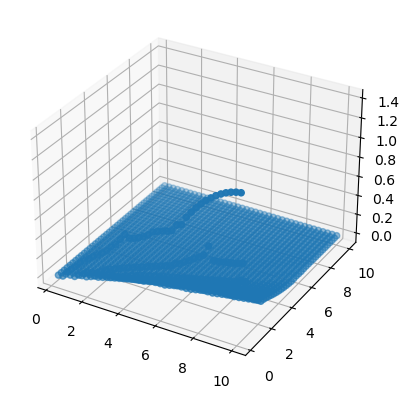

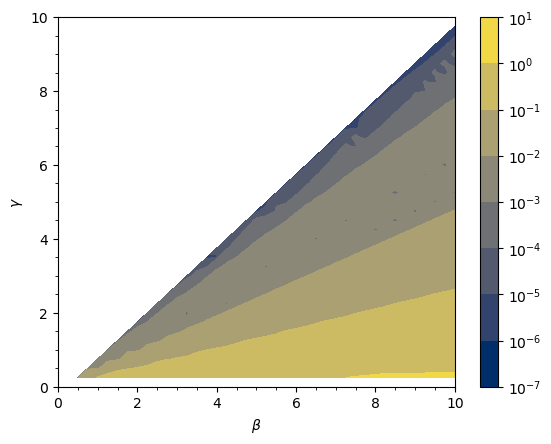

In [34]:
betaPoints = [x[0] for x in points]
gammaPoints = [x[1] for x in points]

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(betaPoints, gammaPoints, borneTab)

minP = int(np.min(np.floor(np.log10(bornes[bornes > 0]))))
maxP = int(np.max(np.ceil(np.log10(bornes[bornes > 0]))))

levels = [10**p for p in range(minP, maxP + 1)]


def my_func(x, pos):
    label = levels[pos]
    print(label)
    return f'$10^{{}}$'


fmt1 = ticker.FuncFormatter(lambda value,pos: ("$10^{%d}$" % int(np.log10(value))))

fig, ax = plt.subplots()
plot = ax.contourf(betas, gammas, np.transpose(bornes),
                   levels=levels, locator=ticker.LogLocator(), cmap='cividis')
plt.xlabel('$\\beta$')
plt.ylabel('$\\gamma$')
plt.colorbar(plot, format=fmt1)
plt.xlim(left=0)
plt.ylim(bottom=0)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter('{x:.0f}')

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(.5))

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter('{x:.0f}')

# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(.5))

fig.savefig('contour.pdf', bbox_inches='tight')

plt.show()
